In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import glob

import torch

import numpy as np
import pandas as pd

import json

from PIL import Image
from matplotlib import pyplot
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

In [2]:
from optimizers import Adan, Lookahead, AGC

In [3]:
from utils import get_score_from_embs

In [4]:
BATCH_SIZE = 64

EMB_DIMS = 768

INPUT_DIR = '../kcg-ml-image-pipeline/output/environmental/ranking_v1/'

VISION_WEIGHT_PATH = './weight/004/environmental/clip_vision.pt'
TEXT_WEIGHT_PATH = './weight/004/environmental/clip_text.pt'

VISION_EMB_PATH = 'data/environmental/clip_vision_emb.npz'
TEXT_EMB_PATH = 'data/environmental/clip_text_emb.npz'

LR = 1e-3

In [5]:
vision_model = torch.nn.Linear(EMB_DIMS, 1, bias=True).cuda().eval()
vision_model.load_state_dict(torch.load(VISION_WEIGHT_PATH))

text_model = torch.nn.Linear(EMB_DIMS * 2, 1, bias=True).cuda().eval()
text_model.load_state_dict(torch.load(TEXT_WEIGHT_PATH))

<All keys matched successfully>

# load emb

In [6]:
npz = np.load(TEXT_EMB_PATH, allow_pickle=True)

text_file_paths = npz['file_paths']

text_positive_embs = npz['positive_pooler_outputs']
text_negative_embs = npz['negative_pooler_outputs']

text_path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(text_file_paths)}

In [7]:
npz = np.load(VISION_EMB_PATH, allow_pickle=True)

vision_file_paths = npz['file_paths']

vision_embs = npz['image_embeds']

vision_path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(vision_file_paths)}

In [8]:
file_paths = list(set(text_path_to_index.keys()) & set(vision_path_to_index.keys()))
path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(file_paths)}

In [9]:
indices = list(map(text_path_to_index.get, file_paths))

text_embs = np.concatenate([text_positive_embs[indices], text_negative_embs[indices]], axis=-1)

indices = list(map(vision_path_to_index.get, file_paths))

vision_embs = vision_embs[indices].astype('float32')

In [14]:
vision_scores = get_score_from_embs(vision_embs, vision_model, BATCH_SIZE)
text_scores = get_score_from_embs(text_embs, text_model, BATCH_SIZE)

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

In [11]:
#

In [12]:
train_indices, val_indices = train_test_split(np.arange(text_embs.shape[0]), test_size=0.2, random_state=42)
np.random.shuffle(train_indices)

In [15]:
train_x = torch.tensor(text_embs[train_indices]).half().cuda()
train_y = torch.tensor(vision_scores[train_indices]).half().cuda()
val_x = torch.tensor(text_embs[val_indices]).half().cuda()
val_y = torch.tensor(vision_scores[val_indices]).half().cuda()

In [ ]:
#

In [195]:
model = torch.nn.Linear(train_x.shape[-1], 1).cuda()

_init_weights(model)

In [196]:
LR = 1e-3
BATCH_SIZE = 1024
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [197]:
scaler = torch.cuda.amp.GradScaler()

mses, val_mses = list(), list()

for epoch in tqdm(range(2000)):
    
    model.train()
    
    for i in range(0, train_x.shape[0], BATCH_SIZE):

        with torch.cuda.amp.autocast(True):

            optimizer.zero_grad()

            y = model(train_x[i:i+BATCH_SIZE])

        # backward

        mse = torch.nn.functional.mse_loss(y, train_y[i:i+BATCH_SIZE, None])
        
        loss = mse

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
        mses.append(mse.detach().cpu().numpy())
        
    with torch.no_grad():
        with torch.cuda.amp.autocast(True):
            y = model(val_x)

            mse = torch.nn.functional.mse_loss(y, val_y[:, None])
    
            val_mses.append(mse.detach().cpu().numpy())
        
    if (epoch + 1) % 100 == 0:
        print(f'{np.mean(mses):.4f} {np.mean(val_mses):.4f}')
        mses, val_mses = list(), list()

  0%|          | 0/2000 [00:00<?, ?it/s]

2.9414 3.0562
2.7090 3.0298
2.7031 3.0447
2.7031 3.0497
2.7031 3.0508
2.7012 3.0513
2.7012 3.0516
2.7012 3.0516
2.7012 3.0515
2.7012 3.0516
2.7012 3.0516
2.7031 3.0516
2.7031 3.0515
2.7031 3.0515
2.7031 3.0516
2.7031 3.0516
2.7031 3.0516
2.7031 3.0514
2.7031 3.0515
2.7031 3.0516


In [36]:
with torch.no_grad():
    with torch.cuda.amp.autocast(True):
        # pred_scores = model(torch.tensor(text_embs).half().cuda()).detach().cpu().numpy()
        mu_sigma = model(torch.tensor(text_embs).half().cuda()).detach().cpu().numpy()
        pred_scores = mu_sigma[..., 0]
        pred_uncertainty = np.abs(mu_sigma[..., 1])

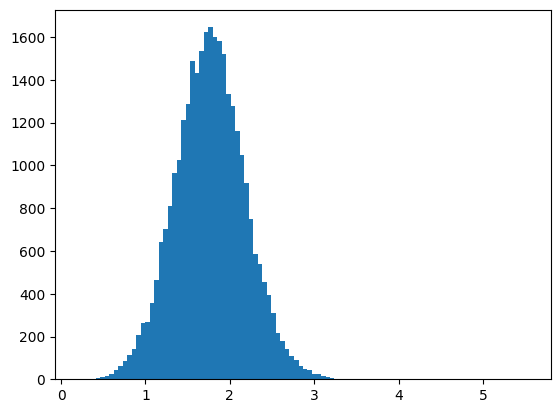

In [37]:
_ = pyplot.hist(pred_uncertainty, bins=100)

In [289]:
import msgpack

In [299]:
with open('../kcg-ml-image-pipeline/output/environmental/ranking_v1/embeddings/006574_embedding.msgpack', 'rb') as f:
    data = f.read()
data = msgpack.unpackb(data)
del data['positive_embedding']
del data['negative_embedding']
data

{'job_uuid': '7aabf828-cbb1-450f-bf2a-fa933a52c113',
 'creation_time': '2023-10-20 09:07:10',
 'dataset': 'environmental',
 'file_path': 'environmental/0007/006574_embedding.msgpack',
 'file_hash': '5f21ad20e06ebe574ea6581f0bb42afb1e3c739677479d74beb9793c2412de24',
 'positive_prompt': 'side scrolling, tile based, 2D side scrolling video game, 2D environmental side scrolling, 2D side scrolling, side scrolling video game, a close up selfie of gorgeous playboy group of nude women in a small kitchen, ultra detailed, sharp focus, (oil painting), beautiful porn model, white box, 1girl, bag, mouth open, golden ratio, eternal sailor moon, full shot body photo of the most beautiful artwork in the world, vivid colors, relaxed',
 'negative_prompt': '(simple background:1.4), mutated hands, bad hands, ((background crowd)), ((cats)), (((mutation))), lowres, badly twisted leg, fewer digits, bad proportions, low quality lowres pokemon, (low quality:2), ((tan lines))'}

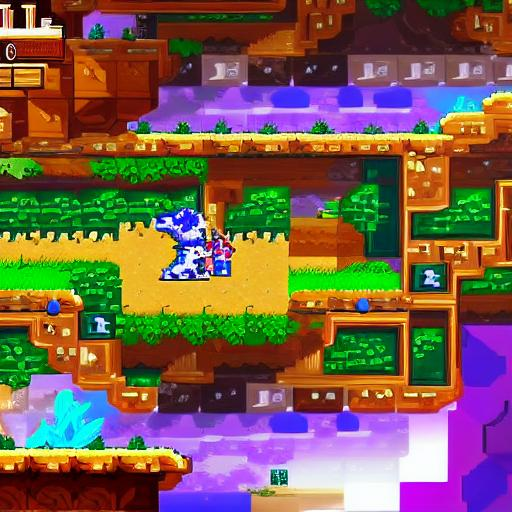

In [303]:
Image.open('../kcg-ml-image-pipeline/output/dataset/image/environmental/0016/015125.jpg')

In [300]:
vision_scores[mask]

array([6.990378 , 7.8704023, 6.330992 , 7.5601954, 6.405093 ],
      dtype=float32)

In [288]:
text_file_paths[np.arange(mask.shape[0])[mask]]

array(['environmental/0007/006574_embedding.msgpack',
       'environmental/0013/012656_embedding.msgpack',
       'environmental/0016/015125_embedding.msgpack',
       'environmental/0018/017578_embedding.msgpack',
       'environmental/0054/053496_embedding.msgpack'], dtype='<U43')

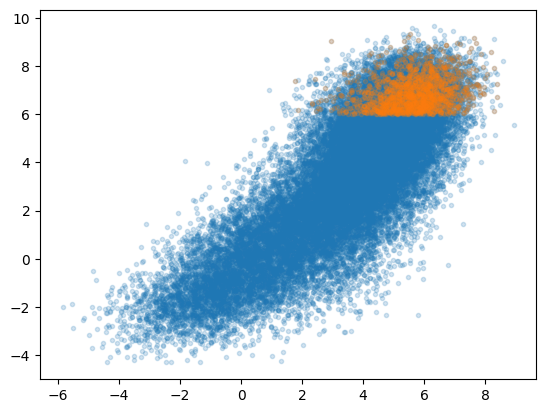

In [38]:
pyplot.plot(pred_scores, vision_scores, '.', alpha=0.2)
mask = (pred_uncertainty < 1.5) * (vision_scores > 6)
# mask = ((pred_scores - pred_uncertainty / 2) > 5)
pyplot.plot(pred_scores[mask], vision_scores[mask], '.', alpha=0.2)

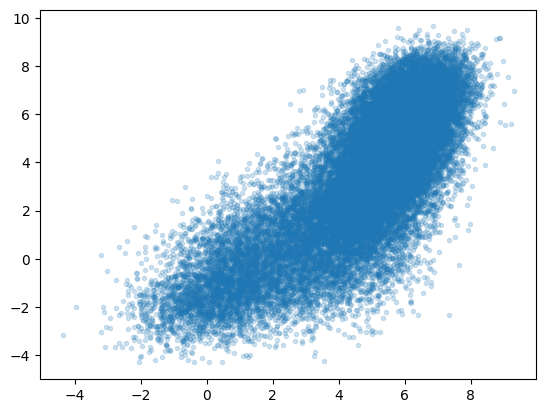

In [39]:
pyplot.plot(text_scores, vision_scores, '.', alpha=0.2)

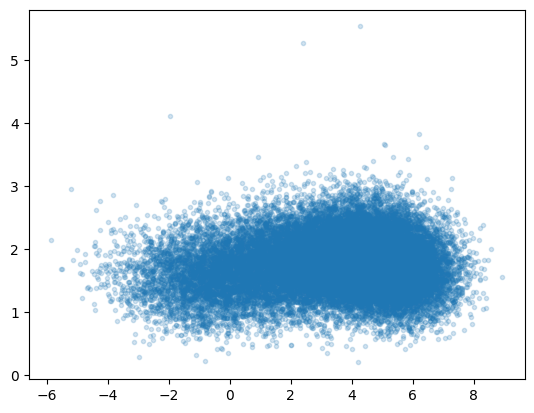

In [40]:
pyplot.plot(pred_scores, pred_uncertainty, '.', alpha=0.2)

# load rank data

In [11]:
paths = sorted(glob.glob(os.path.join(INPUT_DIR, 'ranking_data', '*.json')))

rank_pairs = list()
for path in tqdm(paths):
    js = json.load(open(path))
    
    file_path_1 = os.path.splitext(js['image_1_metadata']['file_path'])[0].replace('datasets/', '')
    file_path_2 = os.path.splitext(js['image_2_metadata']['file_path'])[0].replace('datasets/', '')
    
    if (file_path_1 not in path_to_index) or (file_path_2 not in path_to_index):
        continue
    rank_pairs.append((file_path_1, file_path_2, js['selected_image_index']))

  0%|          | 0/39552 [00:00<?, ?it/s]

In [12]:
rank_pairs = pd.DataFrame(rank_pairs, columns=['image_1', 'image_2', 'selected_image_index'])
ordered_pairs = [((image_1, image_2) if selected_image_index == 0 else (image_2, image_1)) for image_1, image_2, selected_image_index in rank_pairs.itertuples(index=False, name=None)]
ordered_pairs = pd.DataFrame(ordered_pairs, columns=['image_1', 'image_2'])

In [13]:
indices_1 = list(map(path_to_index.get, ordered_pairs['image_1']))
indices_2 = list(map(path_to_index.get, ordered_pairs['image_2']))

In [14]:
# y0, y1, delta = train_y0, train_y1, train_delta
y0, y1 = pred_scores[indices_1], pred_scores[indices_2]

_ = pyplot.hist(y0, bins=100, color='r', alpha=0.5)
_ = pyplot.hist(y1, bins=100, color='b', alpha=0.5)

NameError: name 'pred_scores' is not defined

In [20]:
from utils import init_weights
from optimizers import AGC

In [33]:
model = torch.nn.Linear(train_x.shape[-1], 2).cuda()

init_weights(model)

In [34]:
LR = 1e-3
BATCH_SIZE = 2048
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = AGC(optimizer)

In [35]:
lls, sigmas, mses, val_mses = list(), list(), list(), list()

for epoch in tqdm(range(2000)):
    
    model.train()
    
    for i in range(0, train_x.shape[0], BATCH_SIZE):

        optimizer.zero_grad()

        mu_sigma = model(train_x[i:i+BATCH_SIZE].float())
            
        # backward

        ll = log_likelihood(mu_sigma[..., 0], mu_sigma[..., 1], train_y[i:i+BATCH_SIZE])
        
        mse = torch.nn.functional.mse_loss(mu_sigma[..., 0], train_y[i:i+BATCH_SIZE].float())

        loss = ll + mse

        loss.backward()
        optimizer.step()
    
        lls.append(ll.detach().cpu().numpy())
        sigmas.append(torch.abs(mu_sigma[..., 1]).mean().detach().cpu().numpy())
        mses.append(mse.detach().cpu().numpy())
    
    with torch.no_grad():
        with torch.cuda.amp.autocast(True):
            
            mu_sigma = model(val_x)

            # mse = torch.nn.functional.mse_loss(y, val_y[:, None])
            
            mse = torch.nn.functional.mse_loss(mu_sigma[..., 0], val_y)
    
            val_mses.append(mse.detach().cpu().numpy())
    
    if (epoch + 1) % 100 == 0:
        
        print(f'{np.mean(lls):.4f} {np.mean(sigmas):.4f} {np.mean(mses):.4f} {np.mean(val_mses):.4f}')
        lls, sigmas, mses, val_mses = list(), list(), list(), list()

  0%|          | 0/2000 [00:00<?, ?it/s]

1.2957 2.7813 2.9951 3.1564
1.2418 2.5832 2.6531 2.9763
0.9964 1.7400 2.6243 2.9912
1.0849 2.1425 2.6316 3.0212
1.0582 2.2064 2.6410 3.0382
1.3237 3.0440 2.6384 3.0408
1.2699 3.2344 2.6536 3.0551
1.7778 6.1320 2.7075 3.1006
1.1417 2.2866 2.6151 3.0234
0.9942 1.7441 2.6165 3.0221
1.2837 2.9003 2.6635 3.0865
1.3603 3.6145 2.6518 3.0526
1.1935 2.3907 2.6339 3.0418
1.0415 1.8701 2.6249 3.0422
1.1556 2.4264 2.6389 3.0441
1.1536 2.3006 2.6163 3.0254
1.2930 2.7726 2.6422 3.0501
1.3954 3.9721 2.6530 3.0675
1.1287 2.3435 2.6282 3.0428
1.0847 2.1849 2.6217 3.0333


In [14]:
#

In [15]:
from sklearn.linear_model import LinearRegression

In [76]:
model = LinearRegression()

In [77]:
model.fit(text_embs[train_indices], vision_scores[train_indices])

LinearRegression()

In [78]:
pred_scores = model.predict(text_embs)